# 回归树

## 背景

CART是Classification And Regression Tree，这里以Regression Tree为例预习一下回归树。

回归树，或者广义的决策树的工作原理与传统基于梯度下降迭代的Neural Network，或者直接求解析解的线性回归不太一样，它并不是通过某种线性或者非线性的映射，或者变换来进行预测，实现起来也比较反直觉，它的数据结构是一颗二叉树，详细的实现会在下文展示。

但是它的目的和Linear Regression，Neural Network的目的是相同的，本质上都是希望经验风险或者结构风险最小化。

以一个回归问题为例，Regression Tree的目的也是经验风险或者结构风险最小化，此处以最小化Mean Square Loss为例，当时此处的Loss Function是比较自由的，针对具体的学习任务，换成MAE，或者其他Make Sense的Loss Function也完全可以。

## 数据

首先我们先用几行代码生成一下数据。

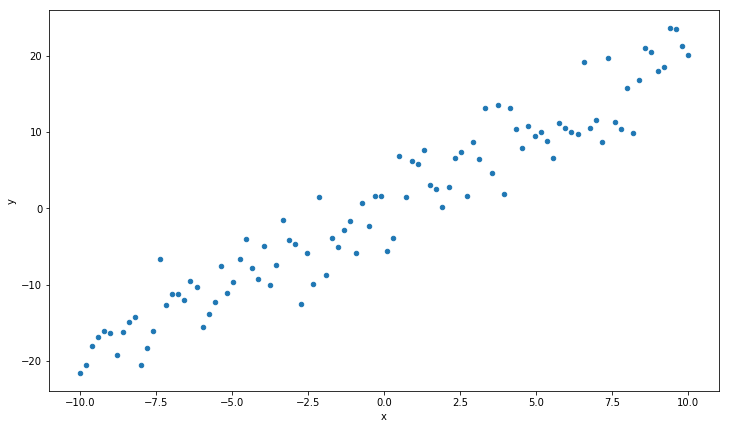

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

x = np.linspace(-10, 10, 100).reshape((-1, 1))
y = np.linspace(-20, 20, 100) + np.random.normal(loc=0, scale=3.5, size=(100, ))

df = pd.DataFrame()
df['x'] = x.reshape((-1, ))
df['y'] = y

df.plot.scatter(x='x', y='y', figsize=(12, 7))

## 算法

我们希望最小化：

$$
\frac{1}{N_1}\sum (y_k - c_1)^2 + \frac{1}{N_2}\sum (y_2 - c_2)^2
$$

只是此处与Linear Regression直接求伪逆与Y的乘积，或者与通过梯度下降与反向传播迭代求解的Neural Network不同，Regression Tree通过以下算法最小化上式的Mean Square Error，具体方法会是这样的：

对于一个Shape为$\ N × M \ $的数据集$X$，即N行M列的数据集$X$，依次逐列遍历逐行，对j列i行，计算下式：

$$ 
\left\{
\begin{aligned}
c_1 &= \frac{1}{N_1} \sum y_{k, j} &  k \in [0, i)\\
c_2 &= \frac{1}{N_2} \sum y_{k, j} &  k \in [i, N]\\
\end{aligned}
\right.
$$

可以看出c1, c2，是对于选定数据集i行j列作为“分割点”后，两个区间内Ground Truth的均值。计算完c1，c2后，将之带入损失函数，计算损失函数的值，并记录之，如果当前c1和c2代表的分割点i, j可以使得损失函数的值最小，那么将这个i, j记为最佳分割，并将数据集切分为$X_1$与$X_2$，构造一个节点（Node），该节点的阈值是$X_{i, j}$，树的深度自增，此时，如果树的深度（Max Depth）为1，那么算法就结束了。通常称这种深度非常浅的决策树（此处为回归树）为决策桩。

这个决策桩将会是这样工作的，对于一个给定的输入向量x，如果它$x[j]$，即向量的第j个下标，小于$X_{i, j}$，那么输出c1，否则输出c2，当然，这样的模型性能是不够的，这个算法还将继续下去。

之后的操作将会是这样的，对切分后的数据集$X_1$与$X_2$，分别重复以上寻找最佳分割（分裂）点的步骤，并切分数据集，直至达到我们设置的停止条件，如树的深度达到设置的最大深度，或者叶子数达到最大叶子数，或者直至数据集不可再次切分。

这个过程中伴随着一颗二叉树的构造，这个构造通常是以深度优先来进行的，即在数据集，或者数据集的子区间完成寻找最佳分割点后，将构造一个树节点，这个节点通常维护了切分点的下标，以及计算出的c1与c2，以及两个孩子节点。详细的数据结构我们会在下文看到。

## 实现

这里以我们生成的数据为例，实现一个简单的回归树，首先我们定义树的结点数据结构：

In [4]:
class Node(object):
    def __init__(self, i, j, c1, c2, l_node=None, r_node=None):
        self.i = i
        self.j = j
        self.c1 = c1
        self.c2 = c2
        self.offset = 0
        self.l_node = l_node
        self.r_node = r_node

可以看出没什么特别的，按照上文描述的，一个节点，维护了最佳切分点的下标，以及给定下标计算出的c1与c2，同时维护了一个下标i相对于原始数据集起始0的偏移，以及左右孩子节点。

接下来我们实现回归树的类，用到了基本的递归生成二叉树与二叉树的先根遍历，这里不再赘述了，一些逻辑写在了注释里：

In [14]:
class Node(object):
    def __init__(self, i, j, c1, c2, l_node=None, r_node=None):
        self.i = i
        self.j = j
        self.c1 = c1
        self.c2 = c2
        self.offset = 0
        self.l_node = l_node
        self.r_node = r_node


class RegressionTree(object):

    def __init__(self):
        self._tree = None
        self.x_data = None
        self.y_data = None
        self.num_nodes = 0

    def fit(self, x, y, max_depth=3):
        self.x_data = x
        self.y_data = y
        # Calculate nodes.
        self.num_nodes = 2 ** max_depth - 1
        # Init root node.
        root_node = self.make_node(x, y)

        def _fit(_x, _y, _node):

            if self.num_nodes <= 0:
                return

            # Make R.
            x_r1, y_r1 = _x[:_node.i], _y[:_node.i]
            x_r2, y_r2 = _x[_node.i:], _y[_node.i:]

            # Make left node.
            l_node = self.make_node(x_r1, y_r1)
            _node.l_node = l_node

            self.num_nodes -= 1

            if _node.l_node:
                # Update offset.
                l_node.offset = _node.offset
                _fit(x_r1, y_r1, _node.l_node)

            # Make right node.
            r_node = self.make_node(x_r2, y_r2)
            _node.r_node = r_node

            self.num_nodes -= 1

            if _node.r_node:
                # Update offset.
                r_node.offset = _node.i + _node.offset
                _fit(x_r2, y_r2, _node.r_node)

        _fit(x, y, root_node)

        self._tree = root_node

    def predict(self, x):

        node = self._tree

        def _predict(_x, _node):

            val = self.x_data[_node.i + _node.offset, _node.j]

            if _x[_node.j] < val:
                if _node.l_node:
                    return _predict(_x, _node.l_node)
                else:
                    return _node.c1
            else:
                if _node.r_node:
                    return _predict(_x, _node.r_node)
                else:
                    return _node.c2

        return _predict(x, node)

    @staticmethod
    def make_node(x, y):
        # Get shape.
        rows, cols = x.shape
        if rows <= 1:
            return None
        # Init params.
        best_i, best_j = 1, 1
        best_c1, best_c2 = 0, 0
        best_loss = np.inf
        # Find best split.
        for i in range(1, rows):
            for j in range(0, cols):
                # Calculate c1, c2, loss.
                c1 = np.mean(y[:i])
                c2 = np.mean(y[i:])
                loss = np.mean(y[:i] - c1) + np.mean(y[i:] - c2)
                # Update best if need.
                if loss < best_loss:
                    best_loss = loss
                    best_i = i
                    best_j = j
                    best_c1 = c1
                best_c2 = c2
        node = Node(best_i, best_j, best_c1, best_c2)
        return node

## 实验

接下来我们对上文生成的数据以不同的最大深度（Max Depth）构造回归树，并检查它的拟合效果，需要注意的是，最大深度其实直接决定了叶子节点的个数，他们的关系会是这样的：

$$
Max\ Leaves = 2^{Max\ Depth} - 1
$$

然后，我们构造并拟合数据，设置`max_depth`从2到4，然后观察他们拟合的效果：

Text(0,0.5,'y')

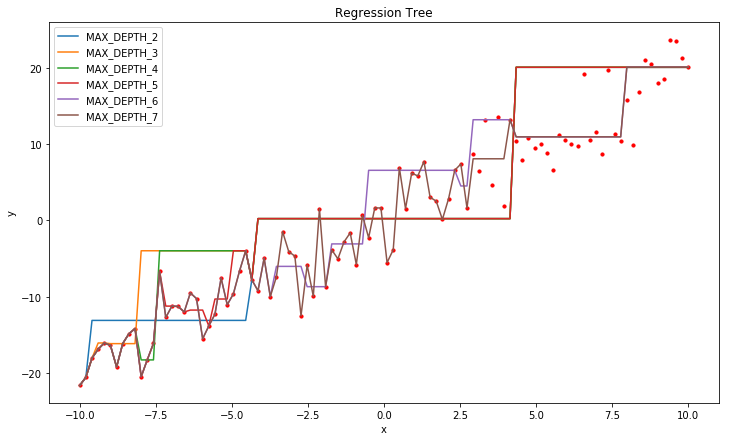

In [19]:
t = RegressionTree()

df = pd.DataFrame()
df['x'] = x.reshape((-1, ))
df = df.set_index('x')
    
for max_depth in range(2, 8):
    
    t.fit(x, y, max_depth=max_depth)
    
    y_predict = [t.predict(x[i, :]) for i in range(0, 100)]
    
    df['MAX_DEPTH_{}'.format(max_depth)] = y_predict
    
plt.figure(figsize=(12, 7))
plt.scatter(x, y, s=10, color='r')

for max_depth in range(2, 8):
    col_name = 'MAX_DEPTH_{}'.format(max_depth)
    plt.plot(x, df[col_name], label=col_name)
    
plt.title('Regression Tree')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')